In [141]:
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
import glob
import sys
import os
import shutil 
import math
import numpy as np
from albumentations.augmentations import transforms
import skimage
from tqdm import tqdm

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from scipy import stats as s

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, GRU
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Convolution2D, ZeroPadding2D, Bidirectional, TimeDistributed
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing import image, sequence
from keras.callbacks import ModelCheckpoint


#from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import optimizers

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(base_dir)
os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

FileExistsError: [Errno 17] File exists: 'data'

In [ ]:
classes = 'Begin, Choose, Connection, Navigation, Next, Previous, Start, Stop, Hello, Web'
classes = classes.split(', ')
classes[:4]

In [23]:
for class_name in classes:
    train_vids_dir = os.path.join(train_dir, class_name)
    val_vids_dir = os.path.join(val_dir, class_name)
    #test_vids_dir = os.path.join(test_dir, class_name)
    
    os.makedirs(train_vids_dir)
    os.makedirs(val_vids_dir)
    #os.makedirs(test_vids_dir)

In [24]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [25]:
train_people = 'F01, F02, F04, F05, F06, F07, F08, F09, M01, M04'.split(', ')
train_people = train_people[:1]
val_people = 'F10, M07'.split(', ')
test_people = 'F11, M08'.split(', ')
print(train_people)
print(val_people)
print(test_people)

classes_num = ['0'+str(i) if i < 10 else str(i) for i in range(1, 11) ]
print(classes_num)
word_ids = ['0'+str(i) if i < 10 else str(i) for i in range(1, 11) ]
print(word_ids)

['F01']
['F10', 'M07']
['F11', 'M08']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


In [26]:
classes_dict = dict(zip(classes_num, classes))
classes_dict['01']

'Begin'

In [35]:
def show_img(img, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img)
    plt.imshow(img)

In [29]:
counter = 0
for classi in classes_num:
    for person in tqdm(train_people):
        for word_id in word_ids:
            for f in sorted(glob.glob(os.path.join('MIRACL/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
                img = cv2.imread(f, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                rects = detector(gray, 0)
                
                for k, rect in enumerate(rects):
                    x1 = rect.left()
                    y1 = rect.top()
                    x2 = rect.right()
                    y2 = rect.bottom()
                    
                    offset_x = (128-(abs(x1-x2)))/2
                    offset_y = (128-(abs(y1-y2)))/2
                    
                    img = img[int(y1-offset_y):int(y2+offset_y), int(x1-offset_x):int(x2+offset_x)]
                
                counter += 1
                
                cv2.imwrite('data/train/' + classes_dict[classi] + '/' + classi + '_' 
                            + person + '_' 
                            + word_id + '_' 
                            + 'frame' + f[29:-4] + '.jpg', img)

100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


In [335]:
kek_rem = [f for f in sorted(glob.glob(os.path.join('data/train/Begin/*.jpg'))) 
           if 'vert_flip' in f
           or 'hor_flip' in f
           or 'rot_45' in f
           or 'rot_315' in f
           or 'rot_135' in f
           or 'rot_225' in f
           or 'rot_90' in f
           or 'rot_270' in f
           or 'rand_contr' in f
           or 'noised' in f]
kek_rem[:10]

['data/train/Begin/01_F01_01_frame001_hor_flip.jpg',
 'data/train/Begin/01_F01_01_frame001_hor_flip_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_hor_flip_rand_contr.jpg',
 'data/train/Begin/01_F01_01_frame001_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rand_contr.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_135.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_135_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_135_rand_contr.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_225.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_225_noised.jpg']

In [336]:
for file_rem in kek_rem:
    os.remove(file_rem)

In [337]:
kek = [f for f in sorted(glob.glob(os.path.join('data/train/Begin/*.jpg'))) 
       if 'vert_flip' not in f 
       and 'hor_flip' not in f 
       and 'rot_45' not in f
       and 'rot_315' not in f
       and 'rot_135' not in f
       and 'rot_225' not in f
       and 'rot_90' not in f
       and 'rot_270' not in f
       and 'rand_contr' not in f
       and 'noised' not in f]
kek[:3]

['data/train/Begin/01_F01_01_frame001.jpg',
 'data/train/Begin/01_F01_01_frame002.jpg',
 'data/train/Begin/01_F01_01_frame003.jpg']

In [338]:
kek[0][:-22] + '[noised]' + kek[0][21:]

'data/train/Begin/[noised]01_01_frame001.jpg'

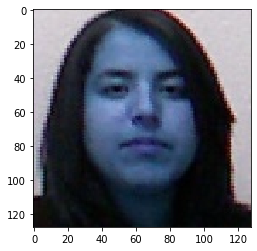

In [339]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.HorizontalFlip().apply(img)
    plt.imshow(img)
    #cv2.imwrite(f[:-4]+'_hor_flip.jpg', img)
    cv2.imwrite(f[:-22] + '[hor_flip]' + f[21:], img)

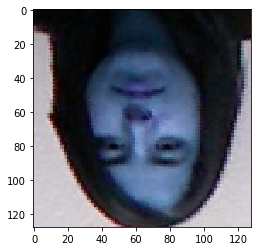

In [340]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.VerticalFlip().apply(img)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[vert_flip]' + f[21:], img)

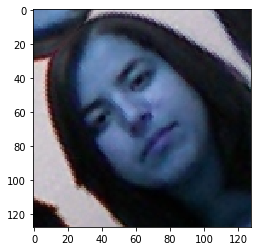

In [341]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.Rotate().apply(img, angle = 45)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[rot_45]' + f[21:], img)

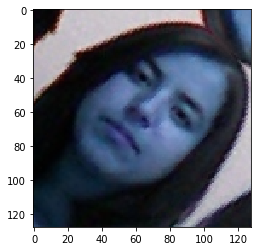

In [342]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.Rotate().apply(img, angle = 315)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[rot_315]' + f[21:], img)

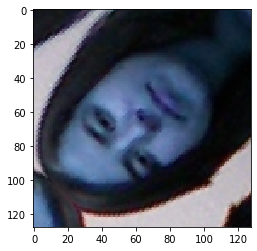

In [343]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.Rotate().apply(img, angle = 135)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[rot_135]' + f[21:], img)

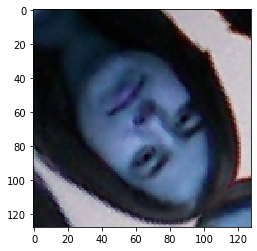

In [344]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.Rotate().apply(img, angle = 225)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[rot_225]' + f[21:], img)

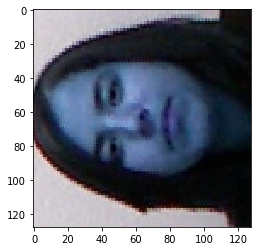

In [345]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.Rotate().apply(img, angle = 90)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[rot_90]' + f[21:], img)

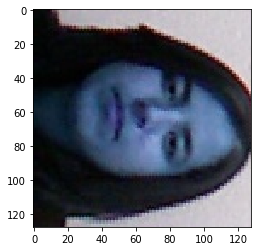

In [346]:
for f in kek:
    img = cv2.imread(f, 1)
    img = transforms.Rotate().apply(img, angle = 270)
    plt.imshow(img)
    cv2.imwrite(f[:-22] + '[rot_270]' + f[21:], img)

In [364]:
kek_all = [f for f in sorted(glob.glob(os.path.join('data/train/Begin/*.jpg'))) if 'noised' not in f]
str(kek[0][:-22]) + '[rand_contr]' + str(kek_all[0].split('/')[3])

'data/train/Begin/[rand_contr]01_F01_01_frame001.jpg'

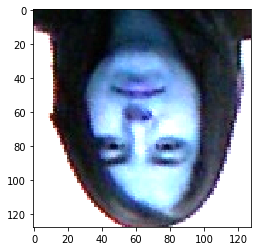

In [367]:
for f in kek_all:
    img = cv2.imread(f, 1)
    img = transforms.RandomContrast().apply(img, alpha=2)
    plt.imshow(img)
    #cv2.imwrite(f[:-22] + '[rand_contr]' + f[21:], img)
    cv2.imwrite(f[:-22] + '[rand_contr]' + f.split('/')[3], img)
    #print(f[:-22] + '[rand_contr]' + f.split('/')[3])

In [313]:
kek_not_contr = [f for f in sorted(glob.glob(os.path.join('data/train/Begin/*.jpg'))) if 'rand_contr' not in f]
kek_not_contr[:10]

['data/train/Begin/01_F01_01_frame001.jpg',
 'data/train/Begin/01_F01_01_frame001_hor_flip.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_135.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_225.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_270.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_315.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_45.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_90.jpg',
 'data/train/Begin/01_F01_01_frame001_vert_flip.jpg',
 'data/train/Begin/01_F01_01_frame002.jpg']

In [368]:
kek_contr = [f for f in sorted(glob.glob(os.path.join('data/train/Begin/*.jpg'))) if 'rand_contr' in f]
kek_contr[:10]

['data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame001.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame002.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame003.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame004.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame005.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame006.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame007.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame008.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame009.jpg',
 'data/train/Begin/[hor_f[rand_contr][hor_flip]01_01_frame010.jpg']

In [369]:
for file_rem in kek_contr:
    os.remove(file_rem)

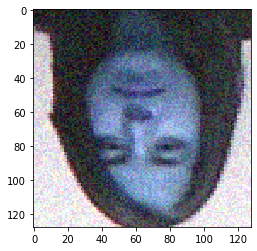

In [316]:
img = cv2.imread(kek_all[0], 1)
gauss = np.random.uniform(0, 64, img.size)
gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')

for f in kek_not_contr:
    img = cv2.imread(f, 1)
    img = cv2.add(img,gauss)
    plt.imshow(img)
    cv2.imwrite(f[:-4]+'_noised.jpg', img)

In [310]:
kek_noised = [f for f in sorted(glob.glob(os.path.join('data/train/Begin/*.jpg'))) if 'noised' in f ]
kek_noised[:10]

['data/train/Begin/01_F01_01_frame001_hor_flip_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_135_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_225_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_270_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_315_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_45_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_rot_90_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame001_vert_flip_rand_contr_noised.jpg',
 'data/train/Begin/01_F01_01_frame002_hor_flip_rand_contr_noised.jpg']

In [311]:
for file_rem in kek_noised:
    os.remove(file_rem)

In [33]:
counter = 0
for classi in classes_num:
    for person in tqdm(train_people):
        for word_id in word_ids:
            for f in sorted(glob.glob(os.path.join('MIRACL/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
                img = cv2.imread(f, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                rects = detector(gray, 0)
                
                for k, rect in enumerate(rects):
                    x1 = rect.left()
                    y1 = rect.top()
                    x2 = rect.right()
                    y2 = rect.bottom()
                    
                    offset_x = (128-(abs(x1-x2)))/2
                    offset_y = (128-(abs(y1-y2)))/2
                    
                    img = img[int(y1-offset_y):int(y2+offset_y), int(x1-offset_x):int(x2+offset_x)]
                
                counter += 1
                
                cv2.imwrite('data/train/' + classes_dict[classi] + '/' + classi + '_' 
                            + person + '_' 
                            + word_id + '_' 
                            + 'frame' + f[29:-4] + '.jpg', img)

100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


In [34]:
counter = 0
for classi in classes_num:
    for person in tqdm(val_people):
        for word_id in word_ids:
            for f in sorted(glob.glob(os.path.join('MIRACL/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
                img = cv2.imread(f, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                rects = detector(gray, 0)
                
                for k, rect in enumerate(rects):
                    x1 = rect.left()
                    y1 = rect.top()
                    x2 = rect.right()
                    y2 = rect.bottom()
                    
                    offset_x = (128-(abs(x1-x2)))/2
                    offset_y = (128-(abs(y1-y2)))/2
                    
                    img = img[int(y1-offset_y):int(y2+offset_y), int(x1-offset_x):int(x2+offset_x)]
                
                counter += 1
                
                cv2.imwrite('data/validation/' + classes_dict[classi] + '/' + classi + '_' 
                            + person + '_' 
                            + word_id + '_' 
                            + 'frame' + f[29:-4] + '.jpg', img)

100%|██████████| 2/2 [00:10<00:00,  5.44s/it]


In [54]:
train_image = []
train_class = []

for class_id in tqdm(range(len(classes))):
    images = sorted(glob.glob('data/train/' + classes[class_id] + '/*.jpg'))
    for i in range(len(images)):
        train_image.append(images[i].split('/')[3])
        train_class.append(classes_dict[images[i].split('/')[3].split('_')[2]])
        
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

train_data.to_csv('MIRACL/train_new.csv',header=True, index=False)

100%|██████████| 10/10 [00:00<00:00, 164.13it/s]


In [55]:
train = pd.read_csv('MIRACL/train_new.csv')
train.head()

,image,class
0,01_F01_01_frame001.jpg,Begin
1,01_F01_01_frame002.jpg,Begin
2,01_F01_01_frame003.jpg,Begin
3,01_F01_01_frame004.jpg,Begin
4,01_F01_01_frame005.jpg,Begin


In [56]:
train.tail()

,image,class
10947,10_M04_10_frame007.jpg,Web
10948,10_M04_10_frame008.jpg,Web
10949,10_M04_10_frame009.jpg,Web
10950,10_M04_10_frame010.jpg,Web
10951,10_M04_10_frame011.jpg,Web


In [57]:
y_tr = train['class']
y_tr_dummy = pd.get_dummies(y_tr)

In [60]:
val_image = []
val_class = []

for class_id in tqdm(range(len(classes))):
    images = glob.glob('data/validation/' + classes[class_id] + '/*.jpg')
    for i in range(len(images)):
        val_image.append(images[i].split('/')[3])
        val_class.append(classes_dict[images[i].split('/')[3].split('_')[2]])
        
val_data = pd.DataFrame()
val_data['image'] = val_image
val_data['class'] = val_class

val_data.to_csv('MIRACL/val_new.csv',header=True, index=False)

100%|██████████| 10/10 [00:00<00:00, 662.85it/s]


In [61]:
val = pd.read_csv('MIRACL/val_new.csv')
val.head()

,image,class
0,01_M07_06_frame008.jpg,Previous
1,01_M07_01_frame001.jpg,Begin
2,01_F10_01_frame005.jpg,Begin
3,01_F10_02_frame002.jpg,Choose
4,01_M07_08_frame004.jpg,Stop


In [62]:
val.tail()

,image,class
1741,10_M07_04_frame001.jpg,Navigation
1742,10_M07_08_frame006.jpg,Stop
1743,10_F10_02_frame001.jpg,Choose
1744,10_F10_08_frame006.jpg,Stop
1745,10_M07_10_frame006.jpg,Web


In [63]:
y_val = val['class']
y_val_dummy = pd.get_dummies(y_val)

In [64]:
print(len(train))
print(len(val))

10952
1746


In [65]:
#conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(128,128,3))

In [67]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [68]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 1024)) #like in conv_pw_13_relu
    labels = np.zeros(shape=(sample_count, 10)) # 10 - num of classes
    generator = datagen.flow_from_directory(
        directory,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical')
    
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

In [69]:
train_features, train_labels = extract_features(train_dir, len(train))

Found 10952 images belonging to 10 classes.


In [71]:
validation_features, validation_labels = extract_features(val_dir, len(val))

Found 1746 images belonging to 10 classes.


In [72]:
print(train_features.shape)
print(validation_features.shape)

(10952, 4, 4, 1024)
(1746, 4, 4, 1024)


In [73]:
import sys
print(sys.getsizeof(train_features)*1e-6)
print(sys.getsizeof(validation_features)*1e-6)

1435.5006879999999
228.851856


In [ ]:
train_features_rnn = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
validation_features_rnn = np.reshape(validation_features, (validation_features.shape[0], 1, validation_features.shape[1]))

In [ ]:
print(train_features_rnn.shape)
print(validation_features_rnn.shape)

In [74]:
# flatten them to (samples, 16384):
train_features = np.reshape(train_features, (10952, 4 * 4 * 1024))
validation_features = np.reshape(validation_features, (1746, 4 * 4 * 1024))

In [75]:
print(train_features.shape)
print(validation_features.shape)

(10952, 16384)
(1746, 16384)


In [ ]:
#model = Sequential()
#model.add(Bidirectional(GRU(256, return_sequences=True, 
#                             kernel_regularizer=l2(0.01), 
#                             recurrent_regularizer=l2(0.01), 
#                             bias_regularizer=l2(0.01)),
#                        input_shape=(1, 1024)))
#model.add(Bidirectional(GRU(256, return_sequences=False, 
#                             kernel_regularizer=l2(0.01), 
#                             recurrent_regularizer=l2(0.01), 
#                             bias_regularizer=l2(0.01))))
#model.add(Dense(10, activation='softmax'))

In [76]:
#model = Sequential()
#model.add(Bidirectional(GRU(256, return_sequences=False, 
#                             kernel_regularizer=l2(0.01), 
#                             recurrent_regularizer=l2(0.01), 
#                             bias_regularizer=l2(0.01)),
#                        input_shape=(1, 1024)))
#model.add(Dense(10, activation='softmax'))

In [79]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 1024))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [80]:
from keras.callbacks import ModelCheckpoint
save_weights = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 4,197,130
Trainable params: 4,197,130
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=128,
                    callbacks=[save_weights],
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10952 samples, validate on 1746 samples
Epoch 1/10
10952/10952 [==============================] - 16s 2ms/step - loss: 3.5571 - acc: 0.3022 - val_loss: 2.2838 - val_acc: 0.0991
Epoch 2/10
10952/10952 [==============================] - 14s 1ms/step - loss: 1.2579 - acc: 0.5031 - val_loss: 2.3684 - val_acc: 0.1140
Epoch 3/10
10952/10952 [==============================] - 15s 1ms/step - loss: 1.0089 - acc: 0.5926 - val_loss: 2.7455 - val_acc: 0.1094
Epoch 4/10
10952/10952 [==============================] - 15s 1ms/step - loss: 0.8169 - acc: 0.6705 - val_loss: 3.1515 - val_acc: 0.1077
Epoch 5/10
10952/10952 [==============================] - 16s 1ms/step - loss: 0.7015 - acc: 0.7154 - val_loss: 3.4247 - val_acc: 0.1214
Epoch 6/10
10952/10952 [==============================] - 15s 1ms/step - loss: 0.6428 - acc: 0.7429 - val_loss: 2.9080 - val_acc: 0.1392
Epoch 7/10
10952/10952 [=========

In [82]:
model.load_weights("weight.hdf5")

In [83]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [85]:
#counter = 0
#for classi in classes_num:
#    for person in tqdm(test_people):
#        for word_id in word_ids:
#            for f in sorted(glob.glob(os.path.join('MIRACL/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
#                img = cv2.imread(f, 1)
#                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#                rects = detector(gray, 0)
#                
#                for k, rect in enumerate(rects):
#                    x1 = rect.left()
#                    y1 = rect.top()
#                    x2 = rect.right()
#                    y2 = rect.bottom()
#                    
#                    offset_x = (128-(abs(x1-x2)))/2
#                    offset_y = (128-(abs(y1-y2)))/2
#                    
#                    img = img[int(y1-offset_y):int(y2+offset_y), int(x1-offset_x):int(x2+offset_x)]
#                
#                counter += 1
#                
#                cv2.imwrite('data/test/' + classes_dict[classi] + '/' + classi + '_' 
#                            + person + '_' 
#                            + word_id + '_' 
#                            + 'frame' + f[29:-4] + '.jpg', img)

In [100]:
files = glob.glob('test_MIRACL/*')
for file_rem in files:
    os.remove(file_rem)

counter = 0
for classi in classes_num:
    for person in tqdm(test_people):
        for word_id in word_ids:
            for f in sorted(glob.glob(os.path.join('MIRACL/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
                img = cv2.imread(f, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                rects = detector(gray, 0)
                
                for k, rect in enumerate(rects):
                    x1 = rect.left()
                    y1 = rect.top()
                    x2 = rect.right()
                    y2 = rect.bottom()
                    
                    offset_x = (128-(abs(x1-x2)))/2
                    offset_y = (128-(abs(y1-y2)))/2
                    
                    img = img[int(y1-offset_y):int(y2+offset_y), int(x1-offset_x):int(x2+offset_x)]
                
                counter += 1
                
                cv2.imwrite('test_MIRACL/' + classi + '_' 
                            + person + '_' 
                            + word_id + '_' 
                            + 'frame' + f[29:-4] + '.jpg', img)

100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


In [101]:
images = glob.glob("test_MIRACL/*.jpg")
test_image = []
test_class = []
for i in tqdm(range(len(images))):
    test_image.append(sorted(images)[i].split('/')[1])
    test_class.append(sorted(images)[i].split('/')[1][:2])


test_data = pd.DataFrame()
test_data['image'] = test_image
test_data['class'] = test_class
test_images = test_data['image']

test_data.to_csv('test_new.csv',header=True, index=False)

100%|██████████| 1639/1639 [00:00<00:00, 1668.42it/s]


In [102]:
test = pd.read_csv('test_new.csv')
y_test = test['class']
y_test = pd.get_dummies(y_test)

test.head()

,image,class
0,01_F11_01_frame001.jpg,1
1,01_F11_01_frame002.jpg,1
2,01_F11_01_frame003.jpg,1
3,01_F11_01_frame004.jpg,1
4,01_F11_01_frame005.jpg,1


In [103]:
video_names = sorted(list(set([test_images[i].split('.')[0][0:9] for i in range(len(test_images))])))
test_videos = pd.DataFrame(video_names)

test_videos.columns = ['dummy']
test_videos = test_videos['dummy']

print(test_videos.shape[0])
test_videos.head()

200


0    01_F11_01
1    01_F11_02
2    01_F11_03
3    01_F11_04
4    01_F11_05
Name: dummy, dtype: object

In [104]:
print(test_images.shape[0])
test_images.tail()

1639


1634    10_M08_10_frame003.jpg
1635    10_M08_10_frame004.jpg
1636    10_M08_10_frame005.jpg
1637    10_M08_10_frame006.jpg
1638    10_M08_10_frame007.jpg
Name: image, dtype: object

In [107]:
predict = []
actual = []

for video_id in tqdm(range(test_videos.shape[0])):
    videoFile = test_videos[video_id]
    
    files = glob.glob('temp/*')
    for f in files:
        os.remove(f)
    
    for frame_id in range(test_images.shape[0]):
        frame = test_images[frame_id]
        if test_images[frame_id].split('.')[0][0:9] == videoFile:
            img = shutil.copyfile('test_MIRACL/'+test_images[frame_id], 'temp/'+test_images[frame_id]) 
    
    images = glob.glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(128,128,3))
        img = image.img_to_array(img)
        img = keras.applications.mobilenet.preprocess_input(img)
        
        prediction_images.append(img)
        
    prediction_images = np.array(prediction_images)
    
    prediction_images = conv_base.predict(prediction_images)
    
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 4 * 4 * 1024)
    
    prediction = model.predict_classes(prediction_images)
    predict.append(y_test.columns.values[s.mode(prediction)[0][0]])
    
    actual.append(int(videoFile.split('_')[0].lstrip('0')))

100%|██████████| 200/200 [01:29<00:00,  2.24it/s]


In [108]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

10.5